# 1 Making the reference catalogues


We need a photometric and astrometric reference. We are going to take the HSC PanSTARRS reference as a base and cross match in the VIDEO JHKs fluxes from HELP. 


The final astrometric reference catalogue will probably be GAIA DR2 astrometry and PanSTARSS plus either 2MASS or the original VISTA catalogues.

In the readme we discuss the changes that have been made to the required format over time. This notebook should show the various changes that we make here including converting fluxes to magnitudes and cross matching in the NIR.



After this has been done these reference catalogues must be ingested according to the instructions given in the DMU2 readme.

In [1]:
from lsst.meas.algorithms.htmIndexer import HtmIndexer
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux

import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import glob
from collections import OrderedDict

In [24]:
ORIG = ''
PS_CATS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/"
PS_CATS19 = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/"
EX_CAT = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/188416.fits"
EX_MS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/master_schema.fits"
MASS_CAT = '../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl'

VHS_CAT = '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_XMM-HSCW02_XMM.fits.gz'

VHS_CATS = glob.glob('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_*.fits.gz')

In [3]:
VHS_CATS

['../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW03_GAMA09_2.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW02_XMM.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW01.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW03_GAMA09_1.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW04_GAMA12_15.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW05_VVDS_1.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW05_VVDS_3.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW05_VVDS_2.fits.gz']

In [4]:
t = Table.read(EX_CAT)

In [5]:
t[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
101240348703435595,0.6086027636676918,-0.09824488799446053,0,2.6317827632738044e-06,3.6596488826035056e-06,3.995693532488076e-06,2.8654415018536383e-06,1.0687740541470703e-05,5.912674510000215e-07,2.089064537358354e-06,4.5423652750287147e-07,5.176063950784737e-07,4.058150580021902e-07,0.0,0.0,1380284288,0.0,0.0,0.0,0.0,0
101240348719679131,0.6086312254866426,-0.09819358176035808,0,1.9323940705362475e-06,2.114941480613197e-06,3.2428818030894035e-06,2.2691024241794366e-06,2.1629517505061813e-05,9.619166121410672e-07,4.181304120720597e-06,9.779163292478188e-07,1.7406183872026304e-07,2.0141085599334474e-07,0.0,0.0,1380287232,0.0,0.0,0.0,0.0,0
101240348725326683,0.6086389808952766,-0.09823105918415859,0,3.117044570899452e-06,3.830545210803393e-06,3.850464963761624e-06,4.498331691138446e-06,8.078391147137154e-06,2.729729544626025e-07,6.593420039280318e-06,4.2184601056760584e-07,4.5649366597899643e-07,5.326427867657912e-07,0.0,0.0,1366466432,0.0,0.0,0.0,0.0,0
101220348728797983,0.6086474507091528,-0.09850114231813084,0,1.8945245301438263e-06,8.214324225264136e-06,1.5255986909323838e-05,1.8216373064205982e-05,2.5504414224997163e-05,4.367411179373448e-07,1.7010578403642285e-06,6.084546839701943e-07,7.225854687931133e-07,6.369347715917684e-07,0.0,0.0,1363572864,-0.0071392995,-0.007713793,0.014461852,0.014395495,0
101220348739597084,0.6086658816126116,-0.09851299344534954,0,2.819050678226631e-06,9.453086022404023e-06,4.5048411266179755e-05,9.451332152821124e-05,0.00013261307321954519,4.063334131387819e-07,1.0634481668603257e-06,4.5210956045593775e-07,1.3810183645546203e-06,4.077786854850274e-07,0.0,0.0,1418507264,0.016156051,0.0050059482,0.0040425425,0.002666546,0


In [6]:
def getShards(ra, dec, radius=1.):
    """Take a region defined by four corners and return shard ids
    
    We want every shard id in the region and for now do not 
    mind about having some ids on the boundary that are not in the region
    
    """
    ra_max = np.max(ra)
    ra_min = np.min(ra)
    dec_max = np.max(dec)
    dec_min = np.min(dec)
    
    htm = HtmIndexer(depth=7)
    all_shards = set()
    for radec in np.nditer(np.meshgrid(
        np.linspace(ra_min,ra_max,   num = int(np.ceil((ra_max-ra_min)/radius))),
        np.linspace(dec_min,dec_max, num = int(np.ceil((ra_max-ra_min)/radius)))
    )):
        
        shards, onBoundary = htm.getShardIds(SpherePoint(radec[0]*degrees, radec[1]*degrees), radius*degrees)
        all_shards = all_shards.union(set(shards))
    return all_shards
ps_refcats = getShards([27.,41.],  [-9,3])
ps_refcats

{133136,
 133137,
 133138,
 133139,
 133140,
 133141,
 133142,
 133143,
 133144,
 133145,
 133146,
 133147,
 133148,
 133149,
 133150,
 133151,
 133152,
 133153,
 133154,
 133155,
 133157,
 133158,
 133159,
 133160,
 133161,
 133162,
 133163,
 133164,
 133165,
 133166,
 133167,
 133168,
 133169,
 133170,
 133171,
 133173,
 133174,
 133175,
 133176,
 133177,
 133178,
 133179,
 133180,
 133181,
 133182,
 133183,
 133184,
 133185,
 133186,
 133187,
 133188,
 133189,
 133190,
 133191,
 133192,
 133193,
 133194,
 133195,
 133196,
 133197,
 133198,
 133199,
 133200,
 133201,
 133202,
 133203,
 133204,
 133205,
 133206,
 133207,
 133208,
 133209,
 133210,
 133211,
 133212,
 133213,
 133214,
 133215,
 133216,
 133217,
 133218,
 133219,
 133220,
 133221,
 133222,
 133223,
 133224,
 133225,
 133226,
 133227,
 133228,
 133229,
 133230,
 133231,
 133232,
 133233,
 133234,
 133235,
 133236,
 133237,
 133238,
 133239,
 133240,
 133241,
 133242,
 133243,
 133244,
 133245,
 133246,
 133247,
 133252,
 

In [7]:
shards_wide = set()
for f in VHS_CATS:
    t = Table.read(f)['RA', 'DEC']
    t['RA'].unit = u.rad
    t['DEC'].unit = u.rad
    t['RA'].convert_unit_to(u.deg)
    t['DEC'].convert_unit_to(u.deg)
    shards_wide = shards_wide.union(getShards(t['RA'],t['DEC']))
    
print(len(ps_refcats), len(shards_wide))

907 2899


In [8]:
ps_refcats = shards_wide

In [27]:
#SCP to download everything you need for the VHS/HSC Wide overlap - this breaks most shells
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
print('scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/{'
      +files[:-1]+'} ./')

scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/{188416.fits,131073.fits,188418.fits,188417.fits,131076.fits,188421.fits,131078.fits,131079.fits,188424.fits,188425.fits,188426.fits,188427.fits,188428.fits,188429.fits,133517.fits,188431.fits,131084.fits,188433.fits,131086.fits,131087.fits,188436.fits,188437.fits,188438.fits,198962.fits,188439.fits,131096.fits,131097.fits,131098.fits,131099.fits,131100.fits,131101.fits,188880.fits,188446.fits,131103.fits,188444.fits,188447.fits,188881.fits,188445.fits,188452.fits,188453.fits,188454.fits,188882.fits,188455.fits,188456.fits,188457.fits,188458.fits,188883.fits,188459.fits,198963.fits,188460.fits,188461.fits,188884.fits,188462.fits,188463.fits,188464.fits,188465.fits,188885.fits,188466.fits,188467.fits,188468.fits,188469.fits,188886.fits,188470.fits,188471.fits,131128.fits,131129.fits,188473.fits,131131.fits,188476.fits,188477.fits,188478.fits,188479.fits,196671.fits,19

In [37]:
#CP to download everything you need for the VHS/HSC Wide overlap
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
with open('../dmu0/dmu0_PanSTARRS/copy_vhs_hsc.sh', 'w') as the_file:
    the_file.write('#!/bin/bash\n')
    the_file.write('# This copies only the shards required to make the VHS/HSC refcats\n')
    the_file.write('mkdir -p ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110/\n')
    the_file.write('cp ./data/ps1_pv3_3pi_20170110/{'
      +files[:-1]+'} ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110/\n')
    the_file.write('tar -czvf ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110.tar.gz ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110/\n')



In [ ]:
#then scp 
#scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/vhs_hsc_subset_ps1_pv3_3pi_20170110.tar.gz .
#tar 

In [10]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (
            (table[col].dtype == float) 
            or (table[col].dtype == 'float32')
            or (table[col].dtype == 'float64')
        ):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [11]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
vega_to_ab = {
    "z":0.502 + 0.004,
    "y":0.600 - 0.022,
    "j":0.916 + 0.0,
    "h":1.366 + 0.019,
    "ks":1.827 - 0.011,
    #"b118":0.853
}

In [12]:
# Bands: Y,J,H,K
imported_columns = OrderedDict({
        'SOURCEID': "id",
        'RA': "ra",
        'DEC': "dec",
        'PSTAR':  "stellarity",
        #'YPETROMAG': "m_vhs_y", 
        #'YPETROMAGERR': "merr_vhs_y", 
        #'YAPERMAG3': "m_ap_vista_y", 
        #'YAPERMAG3ERR': "merr_ap_vista_y",
        #'JPETROMAG': "m_vhs_j", 
        #'JPETROMAGERR': "merr_vhs_j", 
        'JAPERMAG3': "m_ap_vista_j", 
        'JAPERMAG3ERR': "merr_ap_vista_j",        
        #'HPETROMAG': "m_vhs_h", 
        #'HPETROMAGERR': "merr_vhs_h", 
        'HAPERMAG3': "m_ap_vista_h", 
        'HAPERMAG3ERR': "merr_ap_vista_h",        
        #'KSPETROMAG': "m_vhs_k", 
        #'KSPETROMAGERR': "merr_vhs_k", 
        'KSAPERMAG3': "m_ap_vista_ks", 
        'KSAPERMAG3ERR': "merr_ap_vista_ks",
    })


#catalogue = Table.read(VHS_CAT)[list(imported_columns)]
catalogue = Table()

for c in VHS_CATS:
    catalogue = vstack([catalogue,Table.read(c)[list(imported_columns)]])
for column in imported_columns:
    new_col = 'vhs_' + imported_columns[column]
    catalogue[column].name = new_col
    
for col in catalogue.colnames:
    if col.startswith('vhs_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        catalogue[col][mask] = np.nan
        catalogue[col.replace('vhs_m', 'vhs_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        before = np.nanmedian(catalogue[col])
        catalogue[col] += vega_to_ab[col.split('_')[-1]]
        print(col, vega_to_ab[col.split('_')[-1]], np.nanmedian(catalogue[col])-before)
#v_flux = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')
v_flux = catalogue[catalogue['vhs_stellarity'] >= 0.9]

/Users/raphaelshirley/Documents/github/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/numpy/lib/function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


vhs_m_ap_vista_j
vhs_m_ap_vista_j 0.916 0.9160003662109375
vhs_m_ap_vista_h
vhs_m_ap_vista_h 1.366 1.3659992218017578
vhs_m_ap_vista_ks
vhs_m_ap_vista_ks 1.827 1.8269996643066406


In [13]:
#Make empty z2,y2 columns to keep format consistent 
v_flux['vhs_m_ap_vista_z2'] = np.full(len(v_flux), np.nan, dtype='float32')
v_flux['vhs_merr_ap_vista_z2'] = np.full(len(v_flux), np.nan, dtype='float32')
v_flux['vhs_m_ap_vista_y2'] = np.full(len(v_flux), np.nan, dtype='float32')
v_flux['vhs_merr_ap_vista_y2'] = np.full(len(v_flux), np.nan, dtype='float32')

In [14]:
v_flux[:5]

vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks,vhs_m_ap_vista_z2,vhs_merr_ap_vista_z2,vhs_m_ap_vista_y2,vhs_merr_ap_vista_y2
,RADIANS,RADIANS,,,,,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
472880469929,2.4904860198057803,-0.05113532517711659,0.9967527,12.566558,0.0006288282,13.106394,0.00081786653,12.958758,0.0009883484,nan,nan,nan,nan
472880469881,2.490349497168035,-0.05120553159775542,0.9,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
472880469873,2.490607127685092,-0.05120213379248321,0.9,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
472614922809,2.4848264315102213,-0.051771103854805774,0.9,21.533567,0.42432228,nan,nan,nan,nan,nan,nan,nan,nan
472614922771,2.484597352268237,-0.05152533202381338,0.9,21.12641,0.292055,nan,nan,nan,nan,nan,nan,nan,nan


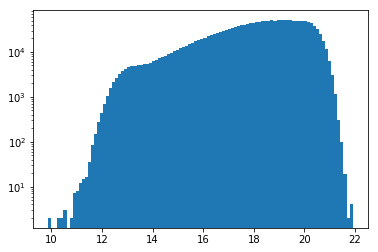

In [15]:
plt.hist(v_flux['vhs_m_ap_vista_ks'], bins=100)
plt.yscale('log')

In [16]:
np.sum(~np.isnan(v_flux['vhs_m_ap_vista_ks']))

1884373

In [17]:
import astropy.units as u

In [18]:
import astropy.units as u
for col in v_flux.colnames:
    if col.startswith('f'):
        v_flux[col] /= 1.E6
        v_flux[col].unit = u.Jansky


In [19]:
v_flux['vhs_ra'].unit = u.rad
v_flux['vhs_dec'].unit = u.rad
v_flux['vhs_ra'].convert_unit_to(u.rad)
v_flux['vhs_dec'].convert_unit_to(u.rad)
#v_flux['ra'].name = 'v_ra'
#v_flux['dec'].name = 'v_dec'

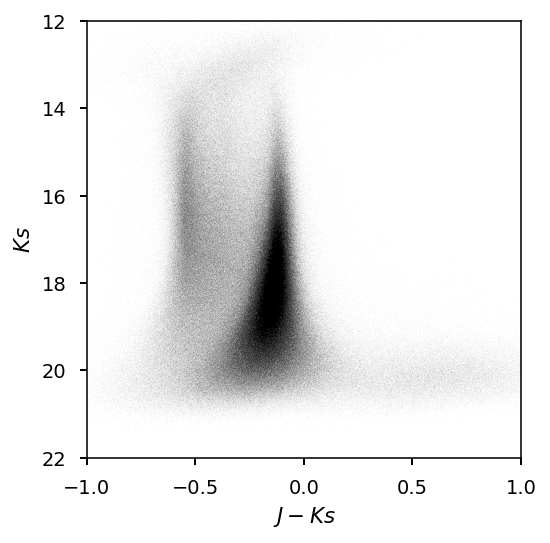

In [21]:

#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(v_flux['vhs_m_ap_vista_j'] - v_flux['vhs_m_ap_vista_ks'],
            v_flux['vhs_m_ap_vista_ks'],
            edgecolors='None', s=0.005, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(22, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [22]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')
    merged_catalogue.remove_column('flag_merged')
    return merged_catalogue

In [39]:
r_cat = Table.read(EX_CAT)

In [40]:
#VHS REF CAT
!mkdir -p data/ref_cats_vhs
n=0
for c in ps_refcats:
    r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/{}.fits".format(c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, v_flux, 'vhs_ra', 'vhs_dec', radius=0.4*u.arcsec)
    merge=clean_table(merge)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['vhs_m_ap_vista_ks']>0.) #Take all panstarrs objects
    )
    merge = merge[has_both]
    if np.sum(merge['vhs_m_ap_vista_ks']>0.) == 0:
        #print('No VHS Objects in ', c)
        continue
    n+=1
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs?
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    merge['pm_ra_err'].name = 'pm_raErr'
    merge['pm_dec_err'].name = 'pm_decErr'
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch'] = merge['epoch'].astype('int32')
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            err_col = col + 'Sigma'
            mag = abMagFromFlux(merge[col])
            mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
            merge[col] = mag
            merge[col].name = col[:-5]
            merge[err_col] = mag_err
            merge[err_col].name = err_col.replace('fluxSigma','err')
        #Go through every vhs mag col and rename
        if col.startswith('vhs_m_'):
            merge[col].name =col.split('_')[-1]
            merge[col.replace('vhs_m_', 'vhs_merr_')].name =  col.split('_')[-1] + '_err'
    if len(merge) == 0:
        print('No Objects in ', c)
        continue
    merge.remove_columns(['vhs_stellarity', 'vhs_id'])
    merge.write('./data/ref_cats_vhs/{}.fits'.format(c), overwrite=True)
    ex=merge.copy()
    print("Shard {} has {} objects and {} VHS mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))


Shard 188416 has 13405 objects and 858 VHS mags.
Shard 188418 has 13134 objects and 860 VHS mags.
Shard 188417 has 13468 objects and 908 VHS mags.
Shard 188421 has 11681 objects and 829 VHS mags.
Shard 188424 has 13475 objects and 776 VHS mags.
Shard 188425 has 13526 objects and 810 VHS mags.
Shard 188426 has 13765 objects and 718 VHS mags.
Shard 188427 has 13221 objects and 827 VHS mags.
Shard 188428 has 11593 objects and 883 VHS mags.
Shard 188429 has 13686 objects and 802 VHS mags.
Shard 133517 has 13073 objects and 478 VHS mags.
Shard 188431 has 13313 objects and 785 VHS mags.
Shard 188436 has 12800 objects and 808 VHS mags.
Shard 188437 has 11674 objects and 809 VHS mags.
Shard 188438 has 10718 objects and 735 VHS mags.
Shard 188439 has 11766 objects and 784 VHS mags.
Shard 188880 has 12349 objects and 1412 VHS mags.
Shard 188446 has 10747 objects and 525 VHS mags.
Shard 188444 has 11430 objects and 999 VHS mags.
Shard 188447 has 10708 objects and 758 VHS mags.
Shard 188881 has 11

Shard 188654 has 11284 objects and 885 VHS mags.
Shard 188655 has 11464 objects and 840 VHS mags.
Shard 188656 has 11758 objects and 299 VHS mags.
Shard 188657 has 13704 objects and 288 VHS mags.
Shard 188659 has 12074 objects and 45 VHS mags.
Shard 188660 has 13527 objects and 311 VHS mags.
Shard 188662 has 12368 objects and 274 VHS mags.
Shard 188663 has 13196 objects and 52 VHS mags.
Shard 188670 has 16483 objects and 43 VHS mags.
Shard 254208 has 15209 objects and 753 VHS mags.
Shard 254209 has 12579 objects and 800 VHS mags.
Shard 254210 has 14112 objects and 687 VHS mags.
Shard 254211 has 13142 objects and 743 VHS mags.
Shard 254216 has 13804 objects and 679 VHS mags.
Shard 254217 has 14707 objects and 771 VHS mags.
Shard 254218 has 11924 objects and 652 VHS mags.
Shard 254219 has 15243 objects and 699 VHS mags.
Shard 254220 has 13319 objects and 740 VHS mags.
Shard 254221 has 14579 objects and 738 VHS mags.
Shard 254222 has 12723 objects and 742 VHS mags.
Shard 254223 has 14625 

Shard 131613 has 12257 objects and 643 VHS mags.
Shard 131614 has 14424 objects and 703 VHS mags.
Shard 131615 has 13857 objects and 682 VHS mags.
Shard 197122 has 13257 objects and 1245 VHS mags.
Shard 197123 has 16360 objects and 1304 VHS mags.
Shard 197145 has 15044 objects and 1127 VHS mags.
Shard 197146 has 13462 objects and 1143 VHS mags.
Shard 131620 has 13888 objects and 171 VHS mags.
Shard 131621 has 12608 objects and 166 VHS mags.
Shard 131623 has 14825 objects and 11 VHS mags.
Shard 131624 has 13733 objects and 188 VHS mags.
Shard 131626 has 12911 objects and 171 VHS mags.
Shard 131627 has 14635 objects and 18 VHS mags.
Shard 131628 has 13217 objects and 15 VHS mags.
Shard 131632 has 14338 objects and 556 VHS mags.
Shard 131633 has 13560 objects and 517 VHS mags.
Shard 131634 has 12588 objects and 498 VHS mags.
Shard 131635 has 14456 objects and 501 VHS mags.
Shard 131636 has 13675 objects and 519 VHS mags.
Shard 131637 has 13868 objects and 505 VHS mags.
Shard 131638 has 13

Shard 156715 has 13890 objects and 1448 VHS mags.
Shard 156716 has 13272 objects and 1546 VHS mags.
Shard 156717 has 14247 objects and 1366 VHS mags.
Shard 156727 has 14206 objects and 1805 VHS mags.
Shard 156728 has 12654 objects and 1214 VHS mags.
Shard 156720 has 12865 objects and 1225 VHS mags.
Shard 156721 has 13663 objects and 1553 VHS mags.
Shard 156722 has 13478 objects and 1239 VHS mags.
Shard 156723 has 13250 objects and 1582 VHS mags.
Shard 255030 has 13231 objects and 203 VHS mags.
Shard 173119 has 12762 objects and 2122 VHS mags.
Shard 197237 has 14371 objects and 1178 VHS mags.
Shard 197238 has 13774 objects and 1209 VHS mags.
Shard 197239 has 13637 objects and 1205 VHS mags.
Shard 238721 has 15643 objects and 2 VHS mags.
Shard 238724 has 15616 objects and 3 VHS mags.
Shard 238726 has 15313 objects and 7 VHS mags.
Shard 156800 has 12989 objects and 1111 VHS mags.
Shard 156801 has 12858 objects and 1269 VHS mags.
Shard 156802 has 12267 objects and 1175 VHS mags.
Shard 1568

Shard 157290 has 13768 objects and 1130 VHS mags.
Shard 157291 has 14143 objects and 1052 VHS mags.
Shard 157292 has 12600 objects and 1093 VHS mags.
Shard 157293 has 13414 objects and 1041 VHS mags.
Shard 157294 has 12551 objects and 1049 VHS mags.
Shard 157295 has 15285 objects and 1073 VHS mags.
Shard 157296 has 13852 objects and 967 VHS mags.
Shard 157297 has 13557 objects and 1207 VHS mags.
Shard 157298 has 13453 objects and 1072 VHS mags.
Shard 157299 has 13812 objects and 1213 VHS mags.
Shard 157300 has 12114 objects and 1126 VHS mags.
Shard 157301 has 11654 objects and 1116 VHS mags.
Shard 157302 has 13618 objects and 1064 VHS mags.
Shard 157303 has 11442 objects and 1081 VHS mags.
Shard 157304 has 13731 objects and 1090 VHS mags.
Shard 157305 has 14753 objects and 991 VHS mags.
Shard 157306 has 14178 objects and 1085 VHS mags.
Shard 157307 has 14620 objects and 1067 VHS mags.
Shard 157308 has 12469 objects and 1120 VHS mags.
Shard 157309 has 13966 objects and 1150 VHS mags.
Sh

Shard 133267 has 13094 objects and 271 VHS mags.
Shard 133268 has 13877 objects and 283 VHS mags.
Shard 133269 has 11241 objects and 465 VHS mags.
Shard 133270 has 11994 objects and 568 VHS mags.
Shard 133271 has 12981 objects and 503 VHS mags.
Shard 133273 has 14120 objects and 358 VHS mags.
Shard 133274 has 11745 objects and 318 VHS mags.
Shard 133275 has 13280 objects and 57 VHS mags.
Shard 133276 has 11692 objects and 483 VHS mags.
Shard 133277 has 11894 objects and 573 VHS mags.
Shard 133278 has 12347 objects and 390 VHS mags.
Shard 133279 has 12998 objects and 448 VHS mags.
Shard 133280 has 12500 objects and 437 VHS mags.
Shard 133281 has 11914 objects and 326 VHS mags.
Shard 133282 has 12415 objects and 621 VHS mags.
Shard 133283 has 11625 objects and 570 VHS mags.
Shard 133285 has 12009 objects and 150 VHS mags.
Shard 133286 has 12923 objects and 35 VHS mags.
Shard 133287 has 12772 objects and 91 VHS mags.
Shard 133288 has 13823 objects and 466 VHS mags.
Shard 133289 has 11485 

Shard 133548 has 13731 objects and 418 VHS mags.
Shard 133549 has 12973 objects and 607 VHS mags.
Shard 133550 has 12080 objects and 470 VHS mags.
Shard 156804 has 13028 objects and 1185 VHS mags.
Shard 133556 has 13380 objects and 529 VHS mags.
Shard 156805 has 13017 objects and 1130 VHS mags.
Shard 133558 has 15906 objects and 636 VHS mags.
Shard 133559 has 14536 objects and 590 VHS mags.
Shard 133560 has 14250 objects and 858 VHS mags.
Shard 133561 has 13174 objects and 252 VHS mags.
Shard 156806 has 12207 objects and 1125 VHS mags.
Shard 133563 has 12873 objects and 701 VHS mags.
Shard 133564 has 11550 objects and 679 VHS mags.
Shard 133565 has 13869 objects and 286 VHS mags.
Shard 133575 has 13221 objects and 661 VHS mags.
Shard 133577 has 14005 objects and 276 VHS mags.
Shard 133578 has 15437 objects and 74 VHS mags.
Shard 156807 has 13017 objects and 1140 VHS mags.
Shard 133571 has 13933 objects and 651 VHS mags.
Shard 156808 has 13125 objects and 1114 VHS mags.
Shard 133573 has

Shard 134081 has 14287 objects and 584 VHS mags.
Shard 134082 has 13691 objects and 577 VHS mags.
Shard 134083 has 14263 objects and 491 VHS mags.
Shard 134084 has 15297 objects and 183 VHS mags.
Shard 134085 has 14413 objects and 58 VHS mags.
Shard 134086 has 13618 objects and 652 VHS mags.
Shard 134087 has 15625 objects and 155 VHS mags.
Shard 134089 has 13308 objects and 232 VHS mags.
Shard 134090 has 11971 objects and 245 VHS mags.
Shard 134091 has 12800 objects and 129 VHS mags.
Shard 134092 has 15641 objects and 457 VHS mags.
Shard 134093 has 15309 objects and 389 VHS mags.
Shard 134094 has 14777 objects and 420 VHS mags.
Shard 134095 has 14239 objects and 382 VHS mags.
Shard 134096 has 15416 objects and 486 VHS mags.
Shard 134097 has 14824 objects and 445 VHS mags.
Shard 134098 has 15997 objects and 805 VHS mags.
Shard 134099 has 14745 objects and 339 VHS mags.
Shard 134101 has 15153 objects and 219 VHS mags.
Shard 134102 has 15645 objects and 38 VHS mags.
Shard 134103 has 15683

Shard 255105 has 13013 objects and 405 VHS mags.
Shard 157412 has 13870 objects and 984 VHS mags.
Shard 189977 has 13291 objects and 1673 VHS mags.
Shard 255106 has 14537 objects and 759 VHS mags.
Shard 157413 has 11778 objects and 829 VHS mags.
Shard 197228 has 13851 objects and 1178 VHS mags.
Shard 189978 has 14272 objects and 1686 VHS mags.
Shard 255107 has 13838 objects and 784 VHS mags.
Shard 189979 has 13149 objects and 1668 VHS mags.
Shard 255108 has 13603 objects and 707 VHS mags.
Shard 189980 has 13472 objects and 1606 VHS mags.
Shard 255109 has 13620 objects and 343 VHS mags.
Shard 189981 has 14989 objects and 1627 VHS mags.
Shard 255110 has 14605 objects and 542 VHS mags.
Shard 189982 has 14970 objects and 1646 VHS mags.
Shard 255111 has 14615 objects and 433 VHS mags.
Shard 197229 has 15154 objects and 1115 VHS mags.
Shard 189983 has 14144 objects and 1506 VHS mags.
Shard 255116 has 14047 objects and 676 VHS mags.
Shard 197230 has 12948 objects and 1044 VHS mags.
Shard 2551

Shard 196647 has 13243 objects and 820 VHS mags.
Shard 196649 has 12373 objects and 84 VHS mags.
Shard 196650 has 12896 objects and 80 VHS mags.
Shard 196651 has 13525 objects and 3 VHS mags.
Shard 196652 has 13137 objects and 857 VHS mags.
Shard 196653 has 12186 objects and 938 VHS mags.
Shard 196654 has 13220 objects and 966 VHS mags.
Shard 196655 has 12690 objects and 864 VHS mags.
Shard 196660 has 13491 objects and 755 VHS mags.
Shard 196661 has 12741 objects and 885 VHS mags.
Shard 196662 has 14604 objects and 820 VHS mags.
Shard 196663 has 12920 objects and 743 VHS mags.
Shard 196666 has 14474 objects and 2 VHS mags.
Shard 196668 has 13837 objects and 83 VHS mags.
Shard 133168 has 14171 objects and 247 VHS mags.
Shard 133169 has 12518 objects and 277 VHS mags.
Shard 196670 has 14225 objects and 90 VHS mags.
Shard 133170 has 12771 objects and 555 VHS mags.
Shard 133177 has 13520 objects and 274 VHS mags.
Shard 199936 has 16540 objects and 1470 VHS mags.
Shard 199937 has 17901 obje

Shard 149626 has 15692 objects and 2287 VHS mags.
Shard 188704 has 11756 objects and 1430 VHS mags.
Shard 149627 has 15969 objects and 2217 VHS mags.
Shard 188705 has 13088 objects and 1365 VHS mags.
Shard 149628 has 16476 objects and 2279 VHS mags.
Shard 188706 has 12910 objects and 1401 VHS mags.
Shard 149629 has 15457 objects and 2244 VHS mags.
Shard 188707 has 13559 objects and 1326 VHS mags.
Shard 149630 has 15516 objects and 2439 VHS mags.
Shard 188708 has 14401 objects and 1421 VHS mags.
Shard 149631 has 15443 objects and 2372 VHS mags.
Shard 188709 has 13827 objects and 1404 VHS mags.
Shard 188710 has 13886 objects and 1441 VHS mags.
Shard 188711 has 15152 objects and 1497 VHS mags.
Shard 188712 has 12489 objects and 956 VHS mags.
Shard 188713 has 12529 objects and 1023 VHS mags.
Shard 188714 has 13045 objects and 1129 VHS mags.
Shard 188715 has 12819 objects and 1020 VHS mags.
Shard 188716 has 13581 objects and 1407 VHS mags.
Shard 188717 has 13269 objects and 1352 VHS mags.
S

In [41]:
ex[:5]

id,coord_ra,coord_dec,parent,g,r,i,z,y,i_err,y_err,r_err,z_err,g_err,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,footprint,j,j_err,h,h_err,ks,ks_err,z2,z2_err,y2,y2_err,coord_raErr,coord_decErr
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
105710312668826723,31.266900068076424,-1.903077323478096,0,22.06641435810028,20.893084937631077,20.382130120970952,20.112657514033504,19.90924230253774,0.013424902151538179,0.038836473016516875,0.04665558247536678,0.027327665068410292,0.0872827460070218,0.0,0.0,1352063616,-0.008522934,0.013158393,0.0073202634,0.007008774,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
105740312671659693,31.26712676626002,-1.875712190136931,0,21.39306546729796,21.21889830796276,21.139764739929284,20.934207462163968,20.87456710889786,0.03545075023215339,0.12950277001373237,0.042910831791731906,0.0708171791475437,0.07771906022477743,0.0,0.0,1342206592,-0.016929105,-0.020294335,0.027473127,0.015450391,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
105720312674755247,31.26750106067088,-1.8959718235873124,0,24.17183162824251,22.91623355948822,21.719338871362837,21.414372969686912,21.256859358496662,0.17537823862875937,0.10238587358524444,0.11745793400917057,0.08038016978047813,0.44501040974761147,0.0,0.0,1409052160,0.17281048,-0.081879325,0.120467626,0.120467626,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
105680312706919644,31.270750553219475,-1.925672420143004,0,20.80529935526687,19.911216454673056,19.539063028447945,19.22486544524666,19.15793770203419,0.007875153081242176,0.03286553219806655,0.028163257587334657,0.01995952080503213,0.04209951506809041,0.0,0.0,1341755520,-0.0036158876,0.0030540018,0.0059497207,0.0048493985,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
105700312707193779,31.270760640457695,-1.9138884215019032,0,23.326776053733752,23.516199591178363,22.852096601753047,23.11177965957967,21.90364360856733,0.1804345390247926,0.22801412235237725,0.15580135041067067,0.8068847449041838,0.25408251481741934,0.0,0.0,1413191808,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
